### Imports and settings

In [103]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.core.display import display
pd.set_option('display.max_columns', None)

/tmp/ipykernel_4641/1281006402.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


### Urls and local storage locations

In [104]:
COINBASE_url = "data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv"
BITSTAMP_url = "data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"

### Preprocessing method for use prior to training

In [105]:
"""Time Series Forecasting of Bitcoin Prices using Keras"""


def preprocess_data(data_url: str) -> pd.DataFrame:
    """converts raw data for use in time series forecasting"""
    
    df = pd.read_csv(data_url)
    df = df[['Timestamp', 'Weighted_Price']]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df['Weighted_Price_filled'] = df['Weighted_Price'].rolling(window=24, min_periods=1).mean()
    df['Weighted_Price'].fillna(df['Weighted_Price_filled'], inplace=True)
    df.drop(['Weighted_Price_filled'], axis=1, inplace=True)
    df.dropna(inplace=True)
    df = df[0::60]
    
    return df


### df Objects

In [106]:
bitDf = preprocess_data(BITSTAMP_url)
coinDf = preprocess_data(COINBASE_url)

### Checking for NaNs

In [109]:

total_rows_with_nan = coinDf.isnull().any(axis=1).sum()
print(coinDf.head())
print(total_rows_with_nan)
print(bitDf.shape)
print(coinDf.shape)


               Timestamp  Weighted_Price
0    2014-12-01 05:33:00      300.000000
82   2014-12-01 06:55:00      370.000000
1783 2014-12-02 11:16:00      377.994792
2317 2014-12-02 20:10:00      378.000000
2926 2014-12-03 06:19:00      378.000000
0
(67260, 2)
(34629, 2)


### Comparison Plots

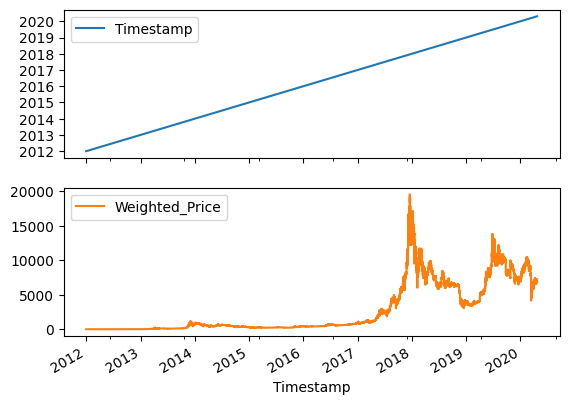

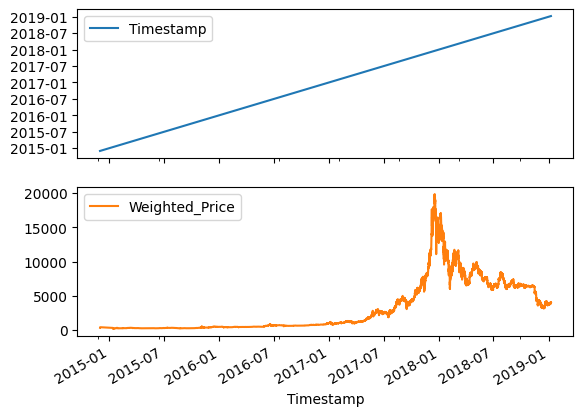

In [108]:
plot_cols = ['Timestamp', 'Weighted_Price']

plot_features = bitDf[plot_cols]
plot_features.index = bitDf['Timestamp']
_ = plot_features.plot(subplots=True)

plot_features = coinDf[plot_cols]
plot_features.index = coinDf['Timestamp']
_ = plot_features.plot(subplots=True)